In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

#### Load the Images

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# change style & content img
# style_img = image_loader("./data/images/neural-style/picasso.jpg")
# content_img = image_loader("./data/images/neural-style/dancing.jpg")
style_img = image_loader("/content/picasso.jpg")
content_img = image_loader("/content/dancing.jpg")

assert style_img.size() == content_img.size()
    # "we need to import style and content images of the same size"

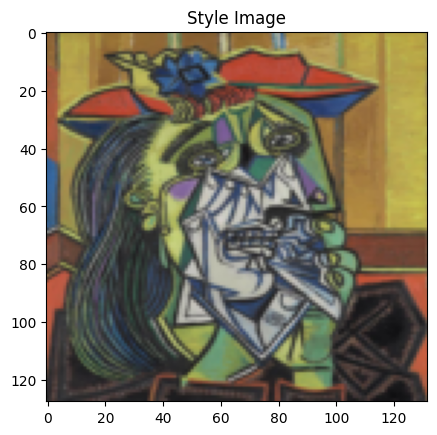

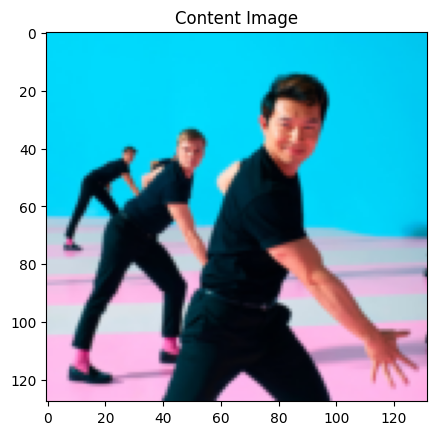

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

#### Loss Functions

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# In order to calculate the style loss, we need to compute the gram matrix.
# A gram matrix is the result of multiplying a given matrix by its transposed matrix.
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input



#### Importing the Model : VGG19

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.3MB/s]


Modified Loss Functions for Guide Question #2


1. Implementing layer-specific weighting


In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               style_weights=None,
                               adjust_layers=None):

    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            print("LAYER SEQUENTIAL")
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss with layer-specific weight
            if style_weights is not None and name in style_weights:
              weight = style_weights[name]
            else:
              weight = 1.0 # default weight

            # check if current layer should have its weight adjusted
            if adjust_layers is not None and name in adjust_layers:
              weight *= 2.0 # adjust weight for layers specified in parameter

            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

    # initialize style weights
    style_weights = {
        'conv_1': 1.5,
        'conv_2': 0.2,
        'conv_3': 1.0,
        'conv_4': 2.5,
        'conv_5': 3.8,
    }

    # layers to adjust weight
    adjust_layers = ['conv_1', 'conv_4']

    # call function with specified parameters
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, cnn_normalization_mean, cnn_normalization_std,
        style_img, content_img,
        style_weights=style_weights,
        adjust_layers=adjust_layers
    )

2. Adding a control parameter for dynamic weighting


In [ ]:
class WeightedLoss(nn.Module):
    def __init__(self, content_weight, style_weight):
        super(WeightedLoss, self).__init__()
        self.content_loss = ContentLoss(target_content)
        self.style_loss = StyleLoss(target_style)
        self.content_weight = content_weight
        self.style_weight = style_weight

    def forward(self, input_image):
        content_loss = self.content_loss(input_image)
        style_loss = self.style_loss(input_image)

        total_loss = (self.content_weight * content_loss + self.style_weight * style_loss)

        return total_loss

3. Adapting the loss function with alternative options

In [ ]:
#Using Feature Reconstruction Loss
class ContentLossV2(nn.Module):
    def __init__(self, target):
        super(ContentLossV2, self).__init__()
        self.target = target.detach()
        self.model = cnn
        self.feature_layer = 15
        self.feature_extractor = nn.Sequential(*list(self.model.children())[:self.feature_layer + 1])
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, input):
        target_features = self.feature_extractor(self.target)
        input_features = self.feature_extractor(input)
        self.loss = F.mse_loss(input_features, target_features)
        return input

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# insert custom loss functions into the imported model

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            print("LAYER SEQUENTIAL")
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

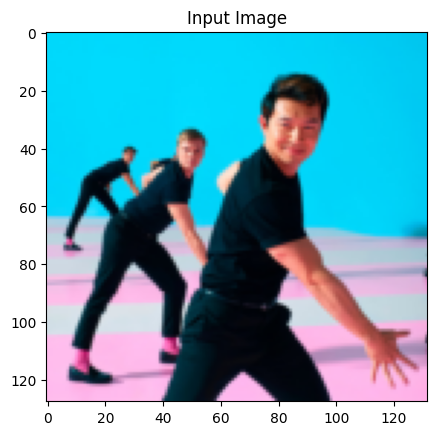

In [ ]:
# select input image

input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
# use LBFGS algorithm to run gradient descent
# it is an optimization algorithm trains machine learning models
# by minimizing errors between predicted and actual results

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

2. In the tutorial, it actually uses a pretrained model called VGG19 (meaning you don’t have
to retrain this model and simply have to use it. Experiment with the pretrained model by
feeding it an image and checking the output.


Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 247.647720 Content Loss: 61.332756

run [100]:
Style Loss : 81.477036 Content Loss: 58.454941

run [150]:
Style Loss : 49.597176 Content Loss: 54.771526

run [200]:
Style Loss : 36.073227 Content Loss: 51.104515

run [250]:
Style Loss : 27.130085 Content Loss: 48.615356

run [300]:
Style Loss : 21.781212 Content Loss: 46.178040



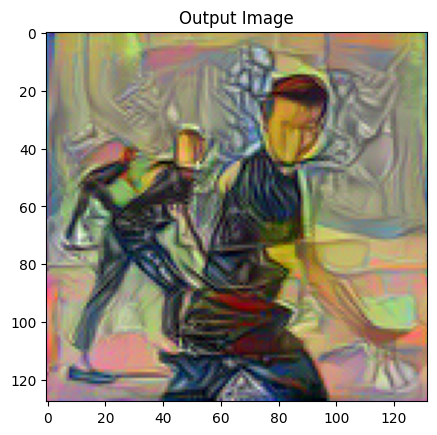

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

3. Choose 2 other pretrained models from pytorch and experiment with it by feeding it an
image to make sure you can call its forward method.

https://pytorch.org/vision/stable/models.html

MODEL 2 : AlexNet

In [ ]:
# test = vgg19(weights=VGG19_Weights.DEFAULT).features
# print(test)

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

cnn = alexnet(weights=AlexNet_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.6MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
# insert custom loss functions into the imported model

# desired depth layers to compute style/content losses :
alexnet_content_layers_default = ['conv_4']
alexnet_style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def alexnet_get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=alexnet_content_layers_default,
                               style_layers=alexnet_style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            print("LAYER SEQUENTIAL")
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

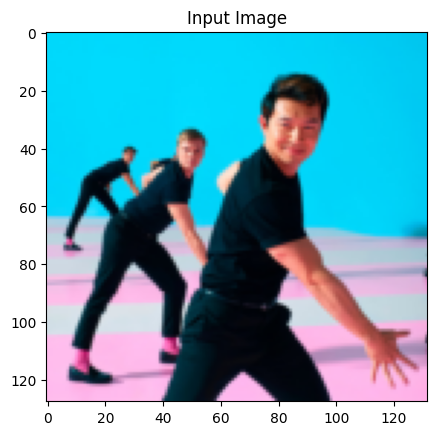

In [ ]:
# select input image

input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
# use LBFGS algorithm to run gradient descent
# it is an optimization algorithm trains machine learning models
# by minimizing errors between predicted and actual results

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = alexnet_get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5752.240234 Content Loss: 173.873627

run [100]:
Style Loss : 2296.814209 Content Loss: 171.896088

run [150]:
Style Loss : 1478.306885 Content Loss: 171.945557

run [200]:
Style Loss : 1134.866577 Content Loss: 171.421341

run [250]:
Style Loss : 904.443237 Content Loss: 169.538788

run [300]:
Style Loss : 747.367554 Content Loss: 168.817276



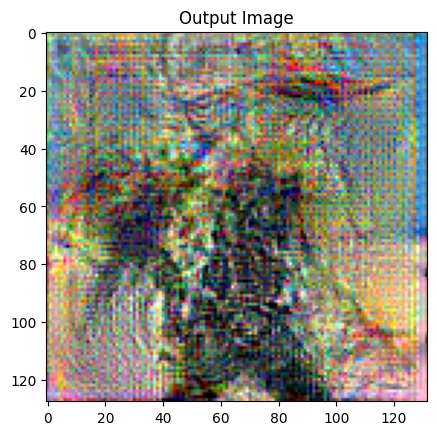

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

MODEL 3 : ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

cnn = resnet50(weights=ResNet50_Weights.DEFAULT).eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


In [ ]:
cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# insert custom loss functions into the imported model

# desired depth layers to compute style/content losses :
resnet_content_layer = ['layer4']
resnet_style_layers = ['layer1', 'layer2', 'layer3', 'layer4']

def resnet_get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=resnet_content_layer,
                               style_layers=resnet_style_layers):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv

    num_input_features = 0
    adjusted_linear = False  # Flag to track if linear layer has been adjusted

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'layer{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu'
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            print("LAYER SEQUENTIAL")
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            print("adaptive_avg_pool")
            target_feature = layer(target_feature)
        elif isinstance(layer, nn.Linear):
            print("Linear")
            target_feature = target_feature.squeeze()  # Remove singleton dimensions
            print("Before linear layer:", target_feature.shape)
            # Calculate the number of input features based on the preceding layer's output size
            num_input_features = target_feature.numel()
            target_feature = target_feature.view(target_feature.size(0), -1)
            print("After flatten:", target_feature.shape)
            break  # Break out of the loop after the first linear layer



        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

   # Adjust the linear layer outside the loop
    cnn[-1] = nn.Linear(num_input_features, cnn[-1].out_features)

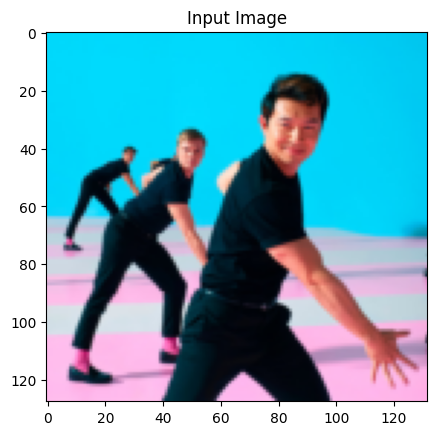

In [ ]:
# select input image

input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
# use LBFGS algorithm to run gradient descent
# it is an optimization algorithm trains machine learning models
# by minimizing errors between predicted and actual results

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def resnet_run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = resnet_get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)


    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= torch.tensor(content_score, dtype=torch.float,
                                          requires_grad=True, device=input_img.device)  # Convert to tensor

            #print('Style Score:', style_score)
            #print('Content Score:', content_score)

            #style_score = torch.tensor(style_score, requires_grad=True, device=device)
            #content_score = torch.tensor(content_loss, requires_grad=True, device=device)

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score


        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
LAYER SEQUENTIAL
LAYER SEQUENTIAL
LAYER SEQUENTIAL
LAYER SEQUENTIAL
adaptive_avg_pool
Linear
Before linear layer: torch.Size([64])
After flatten: torch.Size([64, 1])
Optimizing..
run [50]:
Style Loss : 0.037066 Content Loss: 0.000000

run [100]:
Style Loss : 0.005699 Content Loss: 0.000000

run [150]:
Style Loss : 0.002110 Content Loss: 0.000000

run [200]:
Style Loss : 0.000998 Content Loss: 0.000000

run [250]:
Style Loss : 0.000589 Content Loss: 0.000000

run [300]:
Style Loss : 0.000378 Content Loss: 0.000000



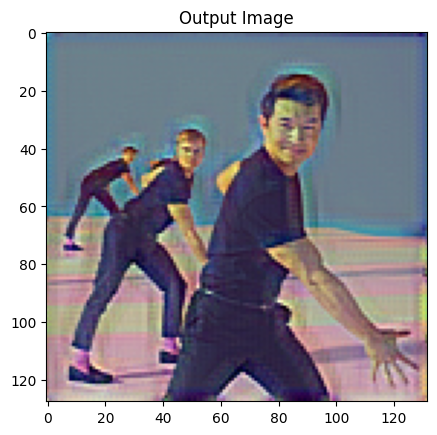

In [ ]:

output = resnet_run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [ ]:
import pickle

#save

4. The neural style transfer model requires a custom loss function. From the tutorial
analyze what this is and make sure you understand the intuition behind its loss
computation

# Guide Questions

2. The loss function for the neural style transfer model is unique. Based on your
understanding of how it works, what tweak can you provide that you think will affect the
performance of the model?

The loss function for the neural style transfer model is unique as it combines content loss and style loss to simultaneously preserve the content of the input image and transfer the style of a reference image. While content loss focuses on maintaining the overall structure and content of the input image, style loss focuses on capturing the stylistic elements of the reference image. This unique approach then allows for the creation of images that are both visually appealing and faithful to the original content.

Based on the group's understanding of how the loss function works, some tweaks that will affect the performance of the model are as follows:

1. Implementing layer-specific weighting
- Instead of applying a single weight to the entire style loss, different weights can be assigned to different layers to allow for more precise control over the specific style elements that are transferred.

2. Adding a control parameter for dynamic weighting
- This enables fine-tuning the trade-off between content preservation and style transfer. Increasing the weight of the style loss will prioritize the image's stylistic elements while decreasing the weight of the style loss will maintain the original content with less emphasis on style transfer.

3. Adapting the loss function with alternative options
- Other types of loss functions can offer additional control over the style transfer process and improve quality of the generated images.